In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

import os
import glob
from PIL import Image
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"]="1"

torch.Size([128, 2, 88, 88])
torch.Size([128, 2, 88, 88]) torch.Size([128])


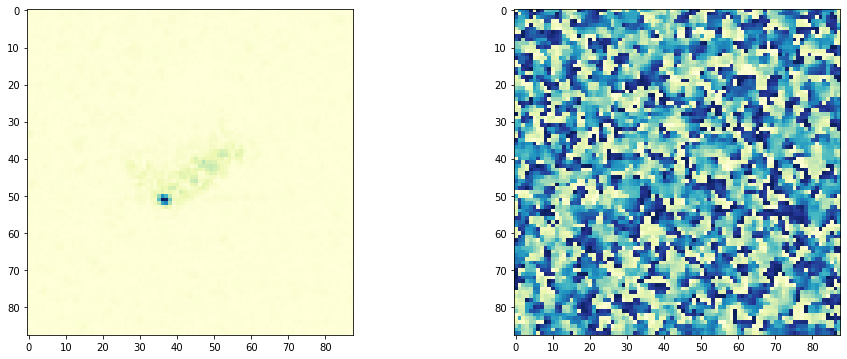

In [2]:
'''Loading the dataset'''
from src.data.mstar import MSTAR
from src.data import preprocess


# name = 'soc'
name = 'eoc-1-t72-a64'
is_train = False
batch_size = 128

transform_mstar = [preprocess.CenterCrop(88), torchvision.transforms.ToTensor()]
_dataset = MSTAR(name=name, is_train=is_train,transform=torchvision.transforms.Compose(transform_mstar))
data_loader = torch.utils.data.DataLoader(_dataset, batch_size=batch_size, shuffle=is_train, num_workers=1)
iter_ = iter(data_loader)

img_tensors = []
for _ in range(1):
    img, _, _ = iter_.__next__()
    img_tensors.append(img)
img_tensors = torch.cat(img_tensors)
print(img_tensors.shape)


'''Visualize the Plot'''

image, label, _ = iter_.__next__()
print(image.shape, label.shape)

fig, ax = plt.subplots(1,2,figsize=[16,6])

ax[0].imshow(image[88,0,:,:],cmap='YlGnBu')
ax[1].imshow(image[2,1,:,:],cmap='YlGnBu')


In [5]:

# https://stackoverflow.com/questions/54727099/activation-gradient-penalty

from src.model.aconvnet import AConvNet

model = AConvNet(in_channel=2)
criterion = nn.CrossEntropyLoss()

print(model)

logits = model(image)
# print(model.intermediate_act)
loss = criterion(logits, label)
grad_params = torch.autograd.grad(loss,model.intermediate_act , create_graph=True, only_inputs=True)



for grad in grad_params:
    print(grad.shape)
    grad_loss = grad.sum()
loss = loss + grad_loss

loss.backward()

AConvNet(
  (layer1): ConvBNReLU(
    (conv): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): ConvBNReLU(
    (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): ConvBNReLU(
    (conv): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer4): ConvBNReLU(
    (conv): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.

In [7]:
'''Captum Defs'''  
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str


def transform_input(img):

    return transforms.Compose(
        [
            transforms.Resize(100),
            transforms.CenterCrop(88),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)

'''TCAV funcs'''
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform_input(img)[:2,:,:]  # WARNING: dirty fix, load in the 2 channel stuff


def load_image_tensors(class_name, root_path='../data/', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')
    assert len(filenames)>0, "Empty filenames"
#     print(filenames)

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform_input(img) if transform else img)
    
    return tensors

def assemble_concept(name, id, concepts_path="../data/conecpts"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['magnitude'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    return fig

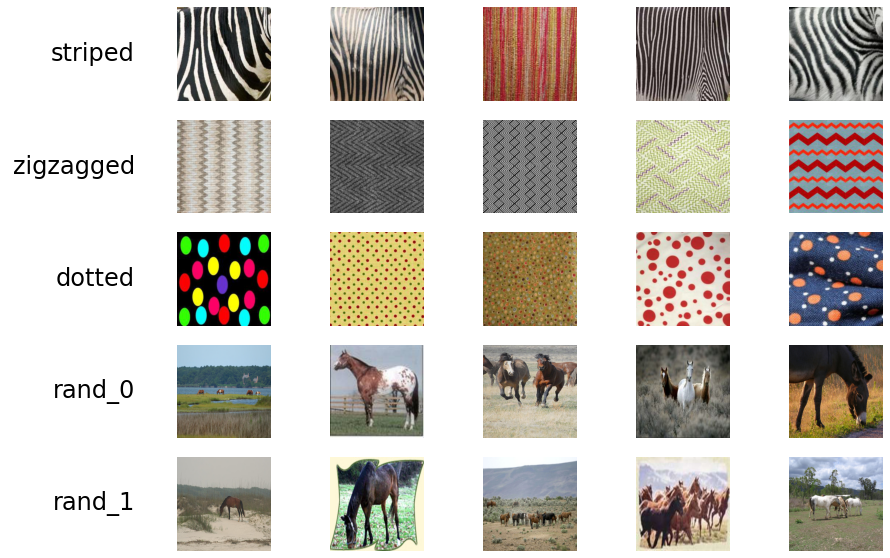

In [8]:
'''Visualize the concepts from pics'''

concepts_path = "../data/concepts/"

stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = assemble_concept("zigzagged", 1, concepts_path=concepts_path)
dotted_concept = assemble_concept("dotted", 2, concepts_path=concepts_path)

random_0_concept = assemble_concept("rand_0", 3, concepts_path=concepts_path)
random_1_concept = assemble_concept("rand_1", 4, concepts_path=concepts_path)

n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (16, 2 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, dotted_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')


In [34]:
from src.model.aconvnet import AConvNet

model_path = './experiments/model/AConvNet-EOC-1-T72-A64/model.pth'
ckpt_sd = torch.load(model_path)

model = AConvNet(2, num_class=10, dropout_rate=0.1)
model.load_state_dict(ckpt_sd)

<All keys matched successfully>

/home/zhaotianchen/nfs/miniconda3/envs/transformer/lib/python3.7/site-packages/captum/concept/_utils/classifier.py:131: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  "Using default classifier for TCAV which keeps input"


torch.Size([32, 2, 88, 88])
Concept(0, 'striped')


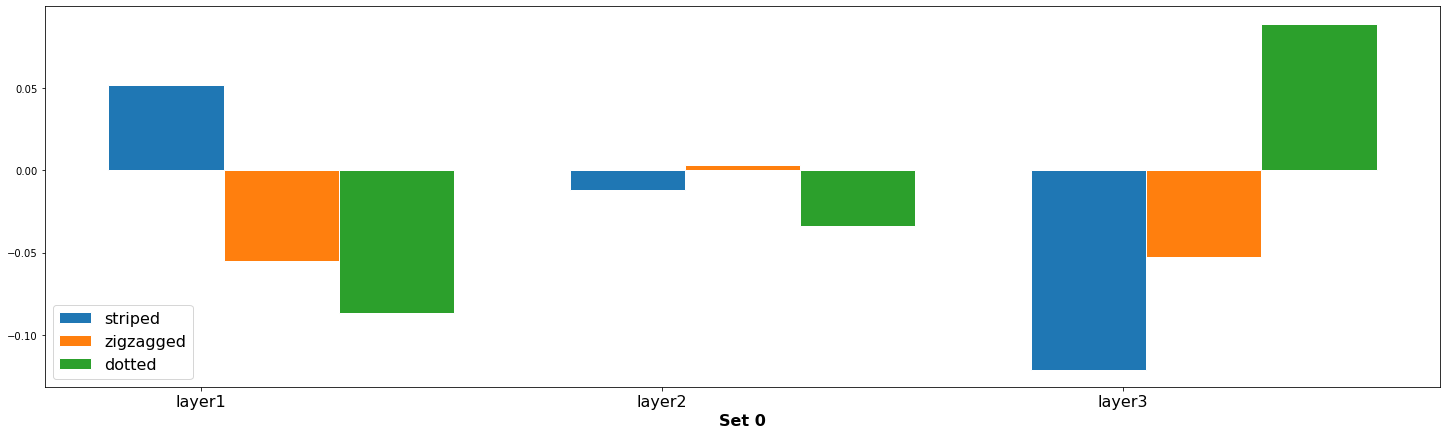

In [10]:
'''TCAV Exmaple Here'''

'''
tensors: [N.C,W,H] should be the same
experimental set: list of conecpts
stripes_concept: Concept:
    - id:
    - name: 
    - data_iter: use Dataloader(CustomIterableDataset(get-tensor-from-filename, filepath))
        - get-tensor-from-filepath: preprocess(read-img)
        - filepath: (file containing)

'''

# print(model)

layers = ['layer1','layer2','layer3']
mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))

print(img_tensors.shape)
print(stripes_concept)



experimental_set_zig_dot = [[stripes_concept, zigzagged_concept, dotted_concept]]
tcav_scores_w_zig_dot = mytcav.interpret(inputs=img_tensors,
                                         experimental_sets=experimental_set_zig_dot,
                                         target=0,
                                         n_steps=1)
fig_tcav = plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot)


torch.Size([1, 2, 88, 88]) 0
Approximation delta:  tensor([0.0447], dtype=torch.float64)
(88, 88, 2) (88, 88, 1)
<class 'numpy.ndarray'>


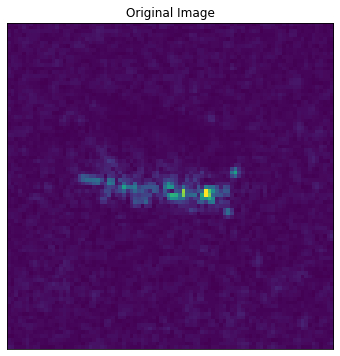

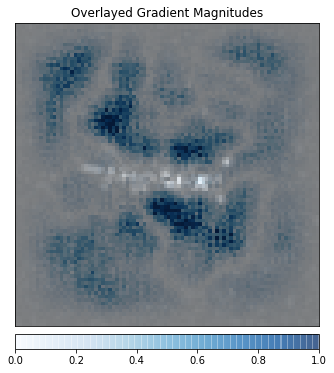

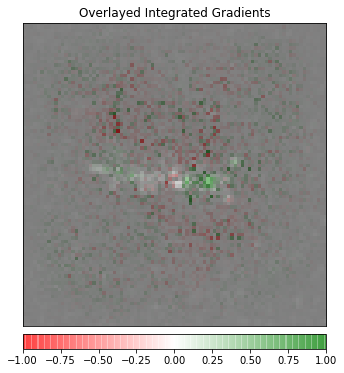

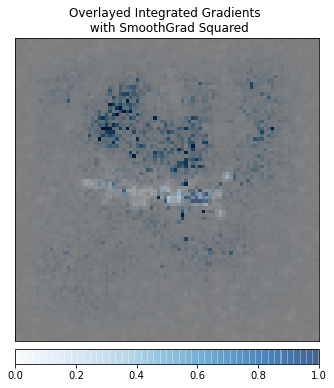

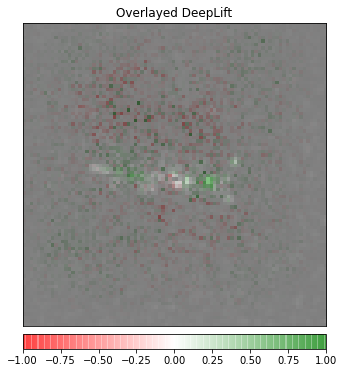

In [49]:
'''Grad Map'''

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

def attribute_image_features(algorithm, input, label, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=label,
                                              **kwargs
                                             )
    
    return tensor_attributions


idx_ = 11
image_ = image[idx_,:].unsqueeze(0)
# image_ = image
label_ = label[idx_].item()
image.requires_grad=True
print(image_.shape, label_)

model.eval()
original_image = np.transpose((image_.squeeze(0).cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

saliency = Saliency(model)
grads = saliency.attribute(image_, target=label_)
grads = np.transpose(grads.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, image_, label=label_, baselines=image_ * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, image_, label=label_, baselines=image_ * 0, nt_type='smoothgrad_sq',
                                      nt_samples=5, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(model)
attr_dl = attribute_image_features(dl, image_, label=label_, baselines=image_ * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

f0 = lambda x: np.expand_dims(x[:,:,0],axis=-1)

original_image = f0(original_image)
# original_image = original_image/10 - 0.4

# grads = grads
# attr_ig = attr_ig[:,:,0]
# attr_ig_nt = attr_ig_nt[:,:,0]
# attr_dl = attr_dl[:,:,0]

print(grads.shape,original_image.shape)

print(type(grads))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")
_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")

AConvNet(
  (layer1): ConvBNReLU(
    (conv): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): ConvBNReLU(
    (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): ConvBNReLU(
    (conv): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer4): ConvBNReLU(
    (conv): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.

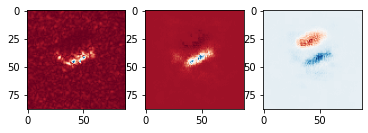

In [195]:
'''The GradCAM Example'''
# https://captum.ai/api/guided_grad_cam.html

from captum.attr import GuidedGradCam

print(model)
# print(image)
guided_gc = GuidedGradCam(model, model.layer2)
guided_gc2 = GuidedGradCam(model, model.layer3)
attribution_gc = guided_gc.attribute(image, 0)  # class-id
attribution_gc2 = guided_gc2.attribute(image, 0)  # class-id

# print(attribution_gc)

fig, ax = plt.subplots(1,3)
ax[0].imshow(image[10][0].detach().numpy(), cmap='RdBu')
ax[1].imshow(attribution_gc[10][0].detach().numpy(), cmap='RdBu')
ax[2].imshow(attribution_gc2[10][0].detach().numpy(), cmap='RdBu')



(88, 88) (88,) (88, 88)


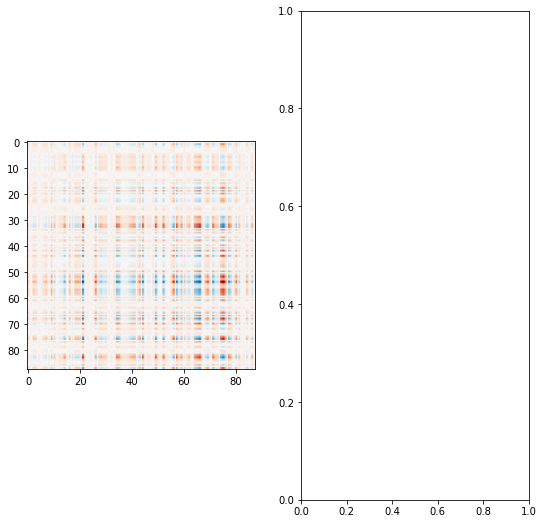

In [124]:
from skimage.filters import gabor_kernel
from skimage import io

# '''Plot the Gabor Kernel'''
# freqs = [0.1, 0.2, 0.5]
# bands = [0.1, 0.2, 0.5]
# fig, ax = plt.subplots(3,3,figsize=[9,9])
# for i_,freq in enumerate(freqs):
#     for j_, band in enumerate(bands):
#         gk = gabor_kernel(frequency=freq, bandwidth=band, theta=band)
#         ax[i_][j_].imshow(gk.real,cmap='RdBu')  
        
# '''FFT Example'''
# a = np.mgrid[:5, :5][0]
# fft_a = np.fft.fft2(image[0][0].detach().numpy())
# fft_a = np.clip(np.fft.fftshift(fft_a.real),-100,100)
# print(fft_a.real)
# fig, ax = plt.subplots(1,1,figsize=[9,9])
# ax.imshow(fft_a, cmap='RdBu')

# from sklearn.decomposition import PCA
# pca = PCA(n_components=4)
# pca.fit(image[0][0].detach().numpy())
# print(pca.explained_variance_ratio_)

u, s, vh = np.linalg.svd(image[0][0].detach().numpy(), full_matrices=True)

print(u.shape, s.shape, vh.shape)
fig, ax = plt.subplots(1,2,figsize=[9,9])


idx = 30
element0 = (np.expand_dims(u[idx,:],0))*(np.expand_dims(vh[:,idx],-1))
# element0 = u[0,:]*vh[:,0].T
ax[0].imshow(element0, cmap='RdBu')
# ax[1].imshow(np.expand_dims(s,-1))


(1, 16)


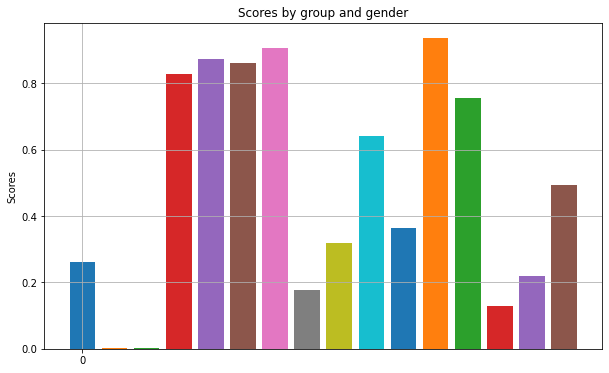

In [213]:
fig, ax = plt.subplots(1,1,figsize=[10,6])

# datas = np.array([ 
#             [0.05,0.4,-0.3,0.2],
#             [0.2,0.4,0.5,-0.3],
# ])

datas = np.random.rand(1,16)

labels_xs = ['layer2','layer4']
# labels_ys = ['FFT','Gabor-A','LPF','HPF']
labels_ys = [f'Gabor_{i}' for i in range(16)]

print(datas.shape)
num_layers = 1
num_rects = 16
rects = []*num_rects
x = np.array(range(num_layers))
scale=20

width = 0.005
for i in range(num_rects):
    rect_ = ax.bar( x+i*width*scale/num_rects , datas[:,i], width, label=f'{labels_ys[i]}')
    rects.append(rect_)

# ax.legend()
ax.grid()
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)